## Import libraries

In [1]:
%matplotlib inline
import io
import os
import numpy as np 
import leafmap
import geopandas as gpd 
import ipywidgets as widgets
from IPython.display import display
import pandas as pd 
from shapely.geometry import Polygon
import datacube
import sys
import folium
import rioxarray
import xarray as xr
import rasterio
from ipywidgets import interactive
import json
from ipywidgets import fixed


#Hide Warnings
import warnings
warnings.filterwarnings('ignore')


# Import functions and set auto-reload
from functions1 import *
%load_ext autoreload
%autoreload 2


## 1. Plot the classified LCZ maps 

###  List the product

In [2]:
dc = datacube.Datacube(app = 'my_app', config = '/home/asi/datacube_conf/datacube.conf')
list_of_products = dc.list_products()
list_of_products

name  \
name                                                       
PRISMA_Full_Bands                      PRISMA_Full_Bands   
PRISMA_classified_images        PRISMA_classified_images   
S2_Full_Bands                              S2_Full_Bands   
Sentinel2_classified_images  Sentinel2_classified_images   
UCP                                                  UCP   
classified_images                      classified_images   
climami                                          climami   
training_samples                        training_samples   

                                                                   description  \
name                                                                             
PRISMA_Full_Bands                          PRISMA imagery containing all bands   
PRISMA_classified_images     PRISMA Classified images using scikit-learn Ra...   
S2_Full_Bands                          Sentinel-2 imagery containing all bands   
Sentinel2_classified_images  Sentinel-2 Classified images using scikit-lear...   
UCP                                                    Urban Canopy Parameters   
classified_images            Classified images using scikit-learn Random Fo...   
climami                      raster data retrived from CLIMAMI Project (Oss...   
training_samples                       Training Samples for LCZ classification   

                            license default_crs default_resolution  
name                                                                
PRISMA_Full_Bands              None        None               None  
PRISMA_classified_images       None        None               None  
S2_Full_Bands                  None        None               None  
Sentinel2_classified_images    None        None               None  
UCP                            None        None               None  
classified_images              None        None               None  
climami                        None        None               None  
training_samples               None        None               None

In [3]:
product_PRISMA = "PRISMA_Full_Bands"
measurements_PRI = dc.list_measurements()

### Load the raster data for Classified maps and Climammi maps

In [4]:
# Load the Classified raster data for PRISMA
product_calssified = "PRISMA_classified_images"
ds_classified_PRI = dc.load(product = product_calssified, output_crs="epsg:32632", resolution=[30,30])


In [5]:
# load the Classified raster data for the sentinel-2
product_calssified = "Sentinel2_classified_images"
ds_classified_S2 = dc.load(product = product_calssified, output_crs="epsg:32632", resolution=[20,20])


In [6]:
# load the climami maps
product_climami = 'climami'
ds_climami = dc.load(product = product_climami, output_crs="epsg:32632", resolution=[30,30])


###  Plot the classified PRISMA & Sentinel-2 image

In [7]:
#select Sensor type 
Sensor = widgets.RadioButtons(
    options=['PRISMA', 'Sentinel-2'],
    value='PRISMA',  # Default to 'PRISMA'
    layout={'width': 'max-content'},
    description='Select Platform:',
    disabled=False
)
Sensor

RadioButtons(description='Select Platform:', layout=Layout(width='max-content'), options=('PRISMA', 'Sentinel-…

In [8]:
#Select Prisma image date
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08', '2023-06-17', '2023-07-10', '2023-08-08'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

Dropdown(description='PRISMA date:', layout=Layout(width='max-content'), options=('2023-02-09', '2023-03-22', …

In [9]:
# SelectSentinel-2 image date
date_s2_w = widgets.Dropdown(
    options=['2023-02-10', '2023-03-22', '2023-04-26', '2023-06-25', '2023-07-10', '2023-08-19'],
    value='2023-02-10',
    description='Sentinel-2 date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_s2_w

Dropdown(description='Sentinel-2 date:', layout=Layout(width='max-content'), options=('2023-02-10', '2023-03-2…

In [10]:
#define the legend for class code,name and color 
legend = {
                   2: ['Compact mid-rise', '#D10000'],
                   3: ['Compact low-rise', '#CD0000'],
                   5: ['Open mid-rise', '#FF6600'],
                   6: ['Open low-rise', '#FF9955'],
                   8: ['Large low-rise', '#BCBCBC'],
                   101: ['Dense trees', '#006A00'],
                   102: ['Scattered trees', '#00AA00'],
                   104: ['Low plants', '#B9DB79'],
                   105: ['Bare rock or paved', '#545454'],
                   106: ['Bare soil or sand', '#FBF7AF'],
                   107: ['Water', '#6A6AFF']
       }

In [11]:
# Create an interactive widget with the update_plot function
interactive_plot = widgets.interactive(
    update_plot,
    ds_classified_PRI=fixed(ds_classified_PRI),
    ds_classified_S2=fixed(ds_classified_S2),
    sensor=Sensor,
    prisma_date=date_prisma_w,
    s2_date=date_s2_w,
    
)
# Display the interactive widget and plots
display(interactive_plot)

interactive(children=(RadioButtons(description='Select Platform:', layout=Layout(width='max-content'), options…

In [13]:
# define the image extent for the selected date
if Sensor.value == 'PRISMA':
    PRISMA_Date_str = date_prisma_w.value
    PRISMA_Date = pd.to_datetime(PRISMA_Date_str)
    Classified = ds_classified_PRI.sel(time=f'{PRISMA_Date}T10:30:00.000000000', method='nearest')['band']
    
    # Get the spatial extent
    xmin, ymin, xmax, ymax = Classified.x.min().values, Classified.y.min().values, Classified.x.max().values, Classified.y.max().values
    extent = (xmin,ymin,xmax,ymax)
    
elif Sensor.value == 'Sentinel-2':
    S2_Date_str = date_s2_w.value
    S2_Date = pd.to_datetime(S2_Date_str)
    Classified = ds_classified_S2.sel(time=f'{S2_Date}T10:30:00.000000000', method='nearest')['band']
    
    xmin, ymin, xmax, ymax = Classified.x.min().values, Classified.y.min().values, Classified.x.max().values, Classified.y.max().values
    extent = (xmin,ymin,xmax,ymax)
    
else:
    raise ValueError("Invalid sensor type. Supported sensors are 'PRISMA' and 'Sentinel-2'.")

### 3/ Plot Climami maps (Temperature maps)

In [14]:
# Get the current directory where the notebook is located
current_directory = os.getcwd()
CLIMAMI_folder_path = '/home/asi/datacube_conf/data/meteo/climami'
# Get a list of GeoTIFF file names in the folder
geotiff_files = [file for file in os.listdir(CLIMAMI_folder_path) if file.endswith('.tif')]


In [15]:
# Create a dropdown widget to display the file names
file_dropdown = widgets.Dropdown(
    options=geotiff_files,
    description='Select a GeoTIFF file:'
)
climami_plot = widgets.interactive(update_climami_plot, ds_climami=fixed(ds_climami),extent=fixed(extent),raster_name=file_dropdown)
# Display the interactive widget and plots
display(climami_plot)

interactive(children=(Dropdown(description='Select a GeoTIFF file:', options=('raster_minima_INVERNO_UHI_2200.…

In [16]:
img1 = selected_lcz(ds_classified_PRI,ds_classified_S2,extent,Sensor.value, date_prisma_w.value, date_s2_w.value)
img2 = selected_climami(ds_climami,extent,file_dropdown.value)

## Plot the climami map with LCZ maps 


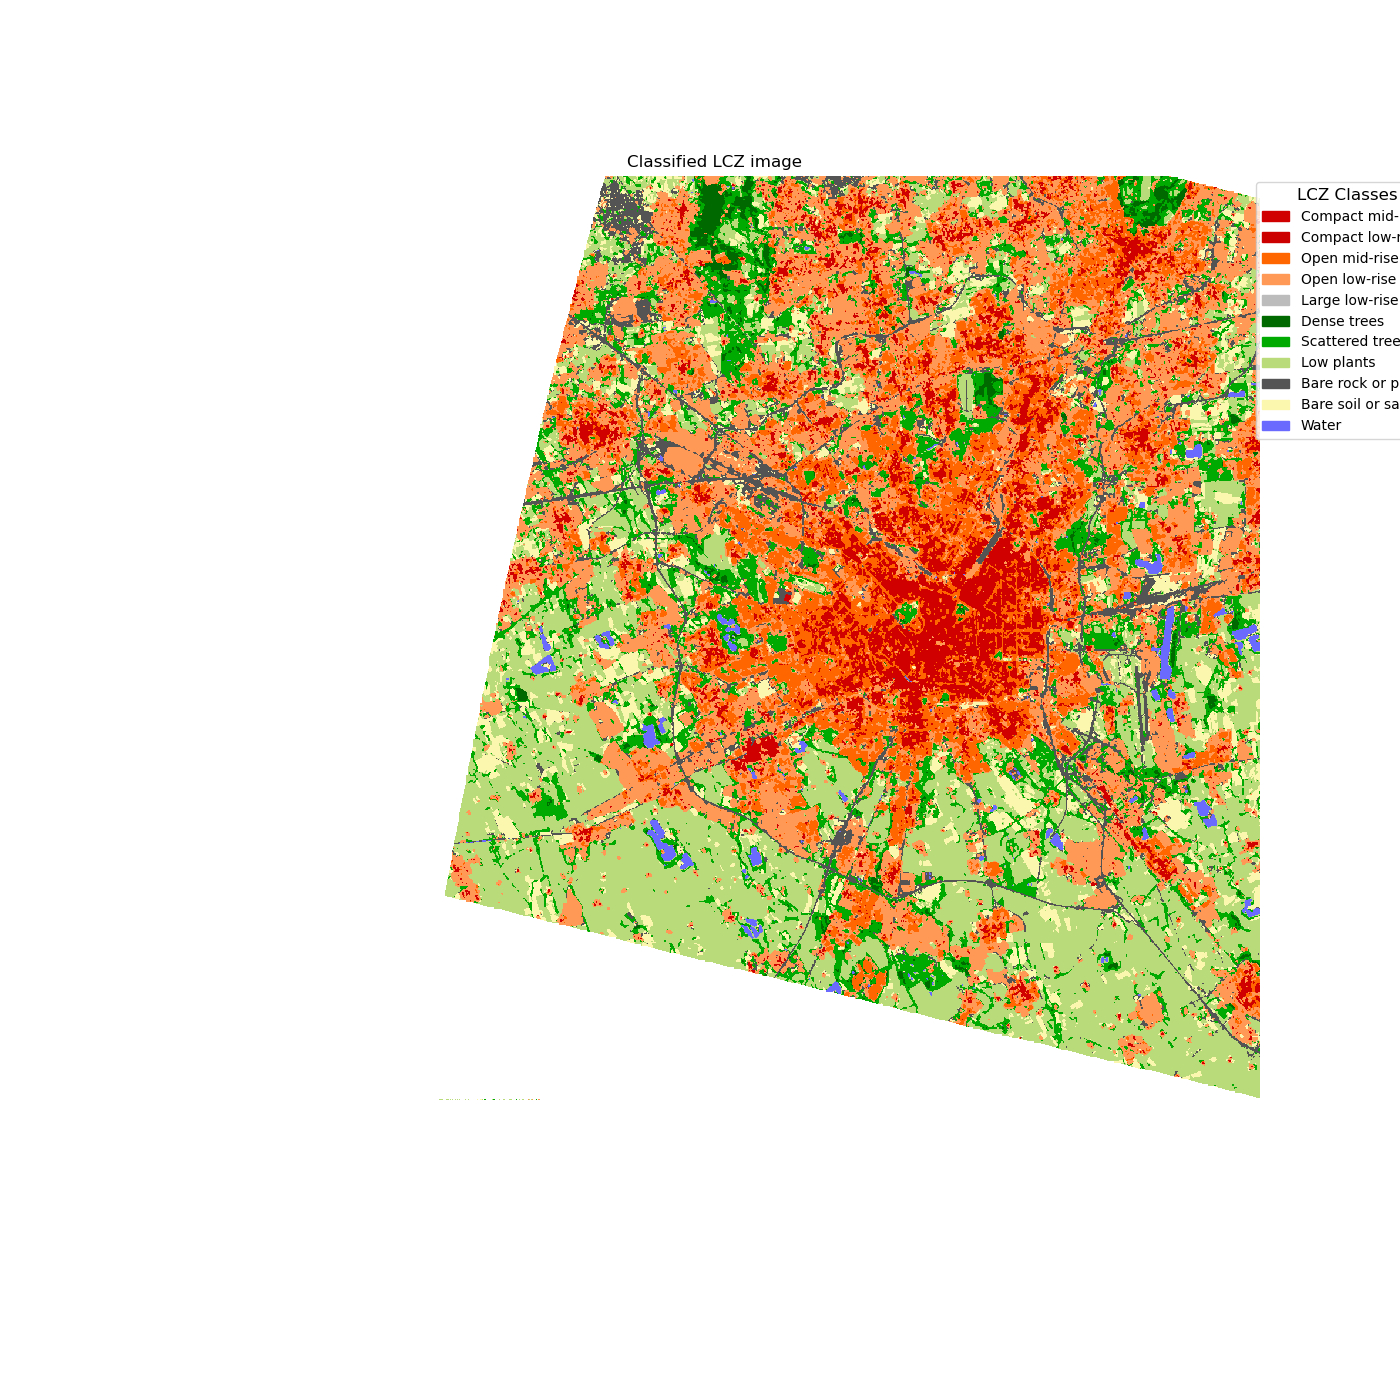
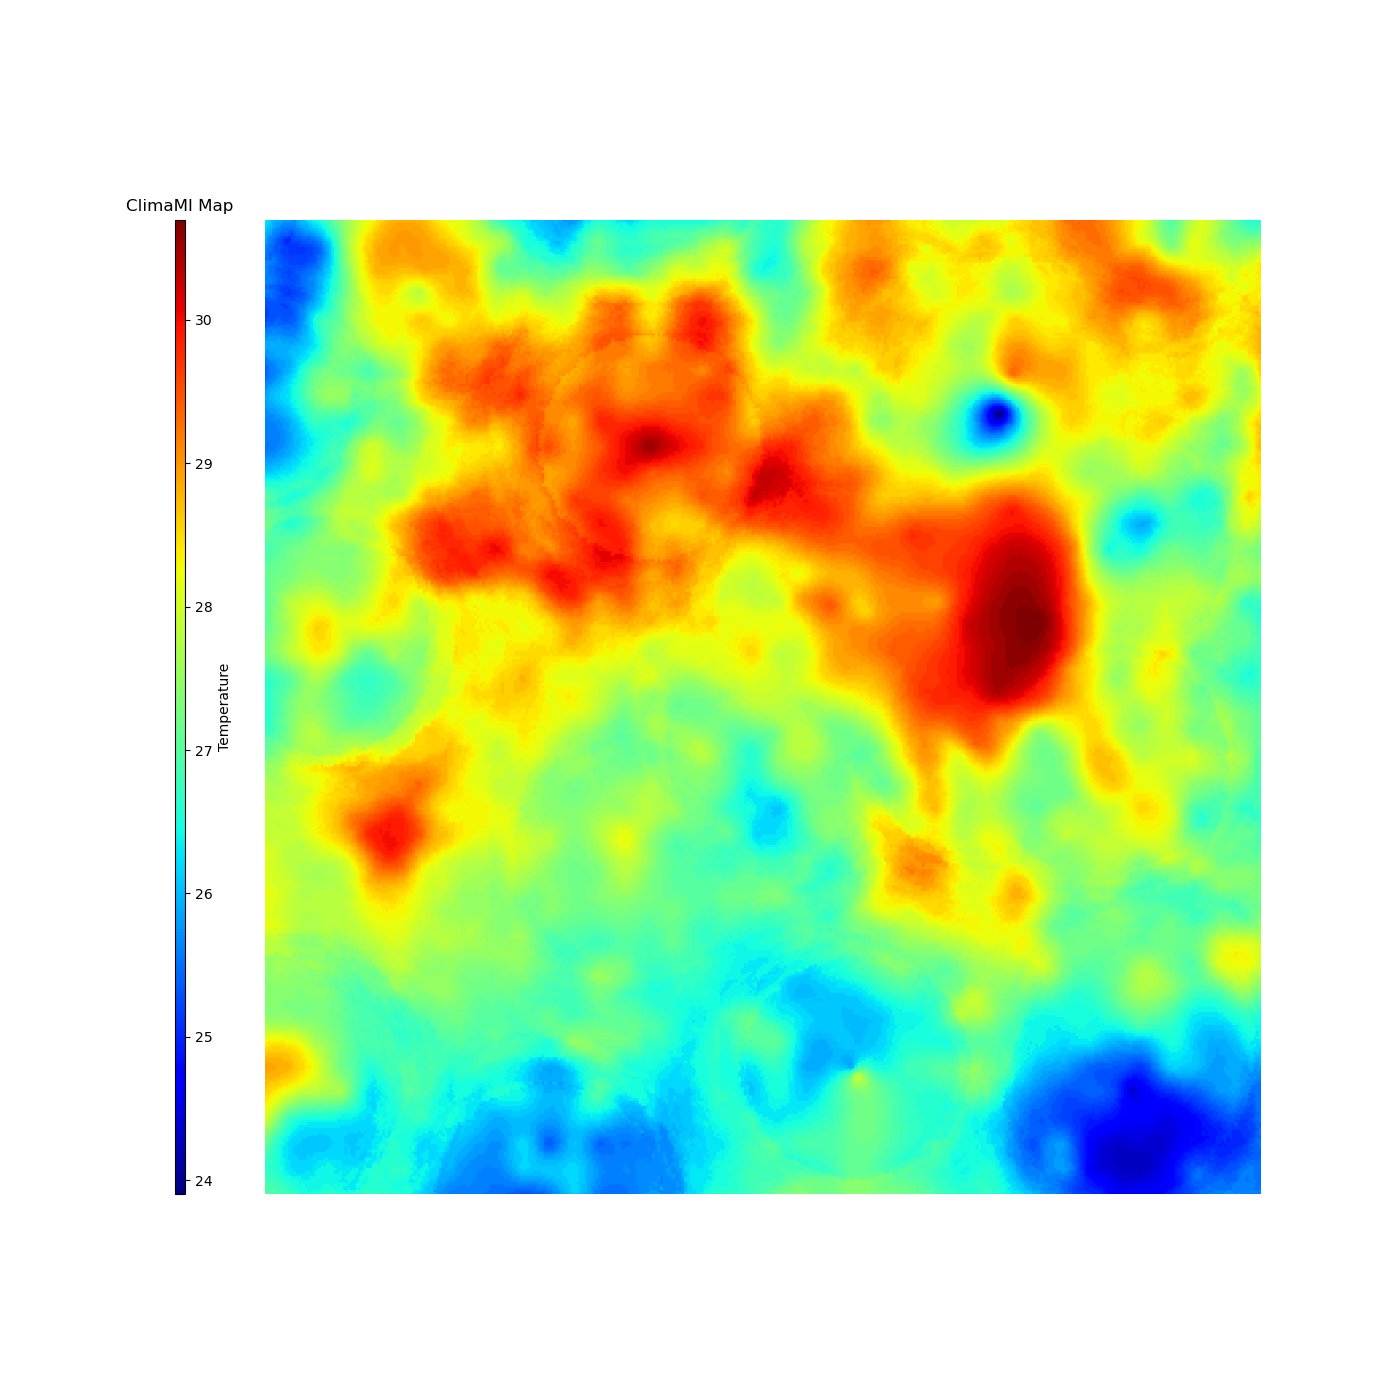

<module 'leafmap' from '/home/asi/.local/lib/python3.8/site-packages/leafmap/__init__.py'>

In [17]:
leafmap.image_comparison(
    img1,
    img2,
    label1='LCZ Image',
    label2='CLIMMAMI',
    starting_position=50,
    
)
leafmap

### Zonal statistics computation

In [18]:
# clip the climami map to lcz map
raster_name = file_dropdown.value
climami = ds_climami.sel(time='2023-02-09T10:30:00.000000000', method='nearest')[raster_name.replace('.tif', '')]

# Clip the raster based on the specified extent
climami_clipped = climami.sel(
    x=slice(extent[0], extent[2]),
    y=slice(extent[1], extent[3])
)
Climami_reprojected = climami_clipped.rio.reproject_match(Classified)
Climami_clipped = Climami_reprojected.rio.clip_box(*Classified.rio.bounds())

In [19]:
result_t = process_zonal_stats(Classified, Climami_clipped, legend)
result_t

zone   count   min   max   mean   std
0     Compact mid-rise   72098  25.3  30.7  29.58  0.85
1     Compact low-rise   76295  25.4  30.7  28.63  0.88
2        Open mid-rise  238051  25.1  30.7  28.65  0.89
3        Open low-rise  281681  24.9  30.7  28.33  0.83
4       Large low-rise  210011  24.4  30.7  28.34  0.87
5          Dense trees   23340  24.0  30.6  27.61  0.89
6      Scattered trees  206663  23.9  30.6  27.93  0.83
7           Low plants  423914  23.9  30.6  27.51  0.72
8   Bare rock or paved  103249  24.4  30.6  28.34  0.92
9    Bare soil or sand  129574  24.9  30.6  27.90  0.79
10               Water   17270  25.4  30.3  27.57  0.60

### Boxplot

In [20]:
df_box = create_boxplot_data(Climami_clipped, Classified)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


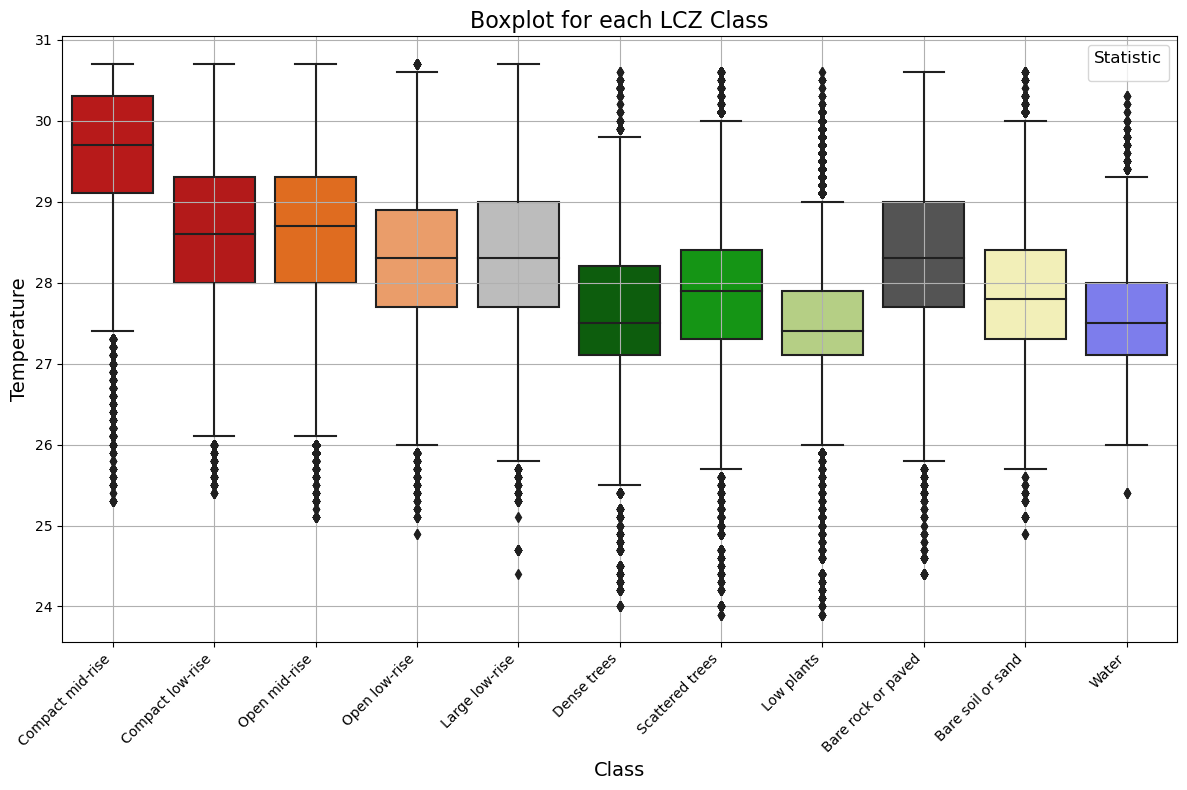

In [21]:
create_boxplot(df_box, legend)